# appetite
## Ridge Regression ML Training

In [1]:
# load packages

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import sys
from sklearn import linear_model

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from backend.server import weather_path
from backend.server import gt_path
from backend.src.data_provider.csv_manager import CSVManager
%matplotlib inline

plt.rcParams['figure.figsize'] = 14, 10

import warnings
warnings.filterwarnings('ignore')

In [2]:
csv_manager = CSVManager(weather_path)
import time
import datetime
from sklearn.metrics import r2_score

class Trainer:
    def __init__(self, model=linear_model.Ridge, label='y'):
        self.columns = []
        self.dataframe = None
        self.test_dataframe = None
        self.model_type = model
        self.model = None
        self.label = label
        self.read_file = []
    
    
    def feed_csv(self, path, columns=[]):
        if 'DATE' not in columns:
            raise Exception("Include DATE as a field")
        
        if path in self.read_file:
            raise Exception("You cannot read the same file twice. {} is already fed to this class".format(path))
            
        # update column
        self.columns += columns
        
        # read data
        csv_manager = CSVManager(path)
        csv_data = csv_manager.read()
        
        csv_data_len = int(len(csv_data))
        csv_data, csv_test_data = csv_data[:csv_data_len - 365], csv_data[csv_data_len - 365:]
        
        def create_data_frame(csv_data, df):
            # get data per column to feed dataframe
            data_per_column = []
            for column in columns:
                # timestamp is handled specially
                if column == 'DATE':
                    timestamps = [datetime.datetime.strptime(data['DATE'], "%Y-%m-%d").month * 100
                                  + datetime.datetime.strptime(data['DATE'], "%Y-%m-%d").day 
                                  for data in csv_data]
                    data_per_column.append(timestamps)
                elif column == 'TRANSACTION':
                    data_at_column = [int(data['STRAWBERRIES']) + random.randint(-3, 3) for data in csv_data]
                    data_per_column.append(data_at_column)
                else:
                    data_at_column = [int(data[column]) for data in csv_data]
                    data_per_column.append(data_at_column)

            # merge new dataframe to the previous dataframe
            new_dataframe = pd.DataFrame(np.column_stack(data_per_column), columns=columns)
            if df is None:
                return new_dataframe
            else:
                return pd.merge(df, new_dataframe, on='DATE')
        
        # training_data ==================================================
        self.dataframe = create_data_frame(csv_data, self.dataframe)
        # testing_data =======================================================
        self.test_dataframe = create_data_frame(csv_test_data, self.test_dataframe)
        
        self.read_file.append(path)
    
    
    def train(self, alpha=.1):
        self.model = self.model_type(alpha=alpha)
        
        features = self.dataframe.copy().drop(columns=self.label)
        self.cof = self.model.fit(features, self.dataframe[self.label])
    
    
    def predict(self, features):
        if self.model is None:
            raise Exception("model is not trained")
        
        return self.model.predict(features)
    
    
    def show_dataframe_graph(self):
        plt.plot(self.dataframe['DATE'], self.dataframe[self.label], '.', ms=16)
    
    
    def test(self):
        prediction = self.model.predict(self.test_dataframe.copy().drop(columns=self.label))

        plt.figure(1)
        plt.title("Prediction")
        plt.plot(self.test_dataframe['DATE'], prediction, '.', ms=16)

        plt.figure(2)
        plt.title("Actual Test Data")
        plt.plot(self.test_dataframe['DATE'], self.test_dataframe['TRANSACTION'], '.', ms=16)

        rss = sum((prediction - self.test_dataframe[self.label]) ** 2)
        print("\n\nQuality Metrics==========================================")
        print("RSS (residual sum of squares): {}".format(rss))
        print("MSE (mean squared error): {}".format(rss/ self.test_dataframe.shape[0]))
        print("R-squared (coefficient of determination): {}".format(r2_score(self.test_dataframe[self.label], prediction)))
        
        """
        print("\n\nWEIGHT==========================================")
        coef_data = [(label, coef) for coef, label in zip(self.get_coef(), ['TAVG', 'DATE', 'TMIN', 'TMAX', 'GOOGLE_TREND'])]
        for cd in coef_data:
            print("{} weight: {}".format(cd[0], cd[1]))
        """
    
    def get_coef(self):
        if self.model == None:
            raise Exception("model hasn't been trained")
        
        return self.cof.coef_
    
    def get_dataframe(self):
        if self.dataframe is None:
            raise Exception("dataframe has not been defined")
        return self.dataframe
    
    def reset(self):
        self.columns = []
        self.regular_data = []
        self.test_data = []
        self.dataframe = None

create_file is not executed since file already exists


create_file is not executed since file already exists
create_file is not executed since file already exists


Quality Metrics==========================================
RSS (residual sum of squares): 1509.498647121189
MSE (mean squared error): 4.135612731838874
R-squared (coefficient of determination): 0.9911208331619831


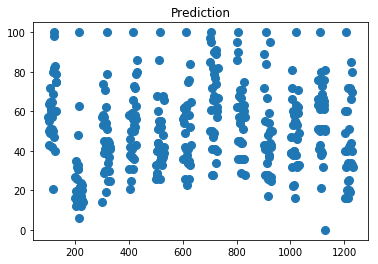

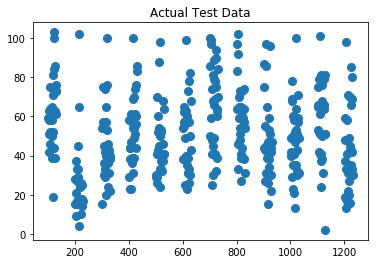

In [3]:
trainer = Trainer(model=linear_model.Ridge, label='TRANSACTION')

trainer.feed_csv(weather_path, columns=['TAVG', 'DATE', 'TMIN', 'TMAX'])
trainer.feed_csv(gt_path, columns=['STRAWBERRIES', 'DATE', 'TRANSACTION'])
data = trainer.get_dataframe()

trainer.train()
trainer.test()

We note that none of the coefficients are 0!